## Today we will work on the movielens dataset. 
* Let's begin with downloading the dataset.
* We will conduct a short exploration within the dataset.
* We will define the kNN algorithm utilizing pearson correalation.



In [ ]:
!wget 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

--2020-10-07 06:50:18--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2020-10-07 06:50:18 (7.64 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
import math
import os
import pandas as pd
import seaborn as sns
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
os.chdir('/content/ml-latest-small')

#Dataset
For calculating the KNN utilizing pearson correlation we need the data driven from the 'ratings' file. 
Let's load it.

In [ ]:
raw_data = pd.read_csv('ratings.csv')
raw_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Exploratory Data Analysis (EDA)
We would like to take a look on the histogram of the ratings within the dataset

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


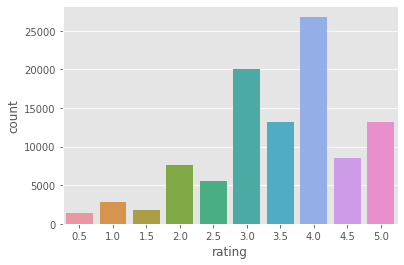

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.countplot(raw_data['rating'])

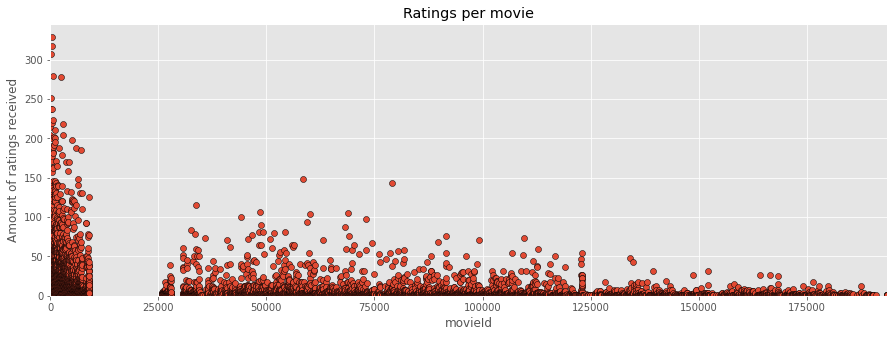

In [ ]:
# Scatter plot of all users and individual ratings count.
dftmp = raw_data[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Amount of ratings received')
plt.show()

**At this notebook we will focus on the items which has more than 50 interactions.**


In [ ]:
more_than_50_ratings = raw_data['movieId'].unique()[raw_data['movieId'].value_counts() > 50]

In [ ]:
print(raw_data.shape)
#data['movieId'].unique()
data = raw_data[raw_data['movieId'].isin(more_than_50_ratings)]
print(data.shape)

(100836, 4)
(24285, 4)


count plot after filtering movies with less than 50 interactions


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


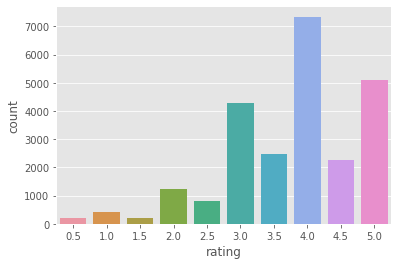

In [ ]:
sns.countplot(data['rating'])

# Utility functions

In [ ]:
def get_data_by_field(data,column_name,column_value):
    """
    This funciton will applying a filter a dataframe

    :param data:  raw dataframe before filter    
    :param column_name:  a specific column name
    :param column_value: a specific value for filter
    :return: sub-dataframe applying a filter on the column_name by the column_value
    """
    return data[data[column_name] == column_value]


In [ ]:
def sanity_checks(input_file_name,user_Id,movie_Id,k):
    """
    This funciton will applying some sanity checks in order to make sure that the inputs are valid.

    :param input_file_name:  inpute file.
    :param user_Id:  user_Id
    :param movie_Id: movie_Id
    :param k: amount of neighbors
    :return: True/False wheater all tests are passed or not. 
    """
    if not os.path.isfile(input_file_name):
            print("Input file doesn't exist or it's not a file")
            return False
    if user_Id not in user_set:
            print("User ID doesn't exist")
            return False

    if movie_Id not in movie_set:
            print("Movie ID doesn't exist")
            return False

    max_k = len(user_set) - 1
    min_k = 1
    k = int(k) # make sure the input is not a float.
    if k < min_k or k > max_k:
        print("k value for k nearest neighbors is not valid, it should be inside [" + str(min_k) + ", " +  str(max_k) +"]")
        return False

    print('Sanity checks are valid')
    return True

    
    

In [ ]:
def user_average_rating(user_data):
    """
    This function return the average rating of a given user.
    :param user_data: a sub-dataframe of a given user.
    :return: the average rating of a given user.
    """
    return user_data['rating'].mean()

In [ ]:
def get_common_items(user1_data,user2_data):
    """
    given user1_data and user2_data get a set of the items consumed by both users.
    :param user1_data: sub dataframe consist of data regards the first user
    :param user2_data: sub dataframe consist of data regards the second user
    :return: a set of the items consumed by both users.
    """   
    items1 = set(user1_data['movieId'])
    items2 = set(user2_data['movieId'])
    return items1 & items2 # & operator stand for intersection. 

In [ ]:
def pearson_correlation(data,user1, user2):
    """
    calculate the pearson correlation between two users
    :param user1_data: user_Id of the first user
    :param user2_data: user_Id of the second user
    :return: the pearson correlation between two users
    """            
    user1_data = get_data_by_field(data, 'userId',user1)
    user2_data = get_data_by_field(data, 'userId',user2)        
    
    rx_avg = user_average_rating(user1_data)
    ry_avg = user_average_rating(user2_data)
    
    same_items = get_common_items(user1_data, user2_data)
            
    if len(same_items) == 0:
        # in case there are no commont items between user1 and user2
        # print('there are no common items between {} and {}'.format(user1,user2))
        return 0.0

    top_result = 0.0
    bottom_left_result = 0.0
    bottom_right_result = 0.0        
    for item in same_items:
        
        rxs = user1_data[user1_data['movieId'] ==item]['rating'].values
        rys = user2_data[user2_data['movieId'] ==item]['rating'].values
        top_result += (rxs - rx_avg)*(rys - ry_avg)
        
        bottom_left_result += pow((rxs - rx_avg), 2)
        bottom_right_result += pow((rys - ry_avg), 2)
    bottom_left_sqrt_result = math.sqrt(bottom_left_result)
    bottom_right_sqrt_result = math.sqrt(bottom_right_result)

    result = top_result/(bottom_left_sqrt_result * bottom_right_sqrt_result)        
    return result   


In [ ]:
def k_nearest_neighbors(data,user, item,k,minimum_additional_items_in_common=0,similarity_treshold=0):
    """
    find the k nearest neighobors of a given user
    :param data: dataframe
    :param user: user_Id 
    :param item: item_Id 
    :param k: integer, indicating the number of neighbors    
    :param minimum_additional_items_in_common: integer, indicating the number of minimum items in common between users in order to be a valid potential neighbor (additional to the examined item)    
    :param similarity_treshold: integer, indicating the minimum similarity score between users in order to be a valid potential neighbor
    :return: list of neighbors
    """   

    neighbors = []
    result = []
    neighbors_to_remove = [] #according to minimum items in common treshold

    potential_neighbor = set(get_data_by_field(data,'movieId',item)['userId'])  #set of all users which rated a given item.  
    potential_neighbor.discard(user) #remove the given user from potential neighbors
    
    # filter potential neighbors according to     
    user_data = get_data_by_field(data, 'userId',user)    
    for pn in potential_neighbor:    
        user2_data = get_data_by_field(data, 'userId',pn)
        if len(get_common_items(user_data,user2_data)) < minimum_additional_items_in_common:
            neighbors_to_remove.append(pn)

    potential_neighbor.difference_update(neighbors_to_remove) # remain with potential neighbors which have more than minimum items in common
    print('Minimum items in common results in filtering {} potential neighbors'.format(len(neighbors_to_remove)))

    print('Potential_neighbors for similarity calculations: ', len(potential_neighbor))
    if len(potential_neighbor) == 0:
        print('Number of potential neighbors is 0')
        return result
        
    for pn in potential_neighbor:
        pn_pearson_corr = pearson_correlation(data,user, pn)
        if pn_pearson_corr >= similarity_treshold:
            neighbors.append([pn, pn_pearson_corr])        

    print('Loop over potential neighbors')
    sorted_neighbors = sorted(neighbors, key=lambda neighbors: (neighbors[1], neighbors[0]), reverse=True)   # - for desc sort
    
    min_neighbors = min(k,len(sorted_neighbors))
    for i in range(min_neighbors):
        result.append(sorted_neighbors[i])
    
    if(len(result) < k):
        print('Due to filtering threshold reasons, there are less than {} users that match all thresholds. \n Here are the users who pass all thresholds:'.format(k))
    return result

In [ ]:
def predict(data,user, item,knn):
    """
    predict the rating using K nearest neighbors for a givne user and item
    :param data: dataframe
    :param user: user_Id 
    :param item: item_Id     
    :param knn: list of similariy derived from knn function
    :return: predicted rating
    """   
    user_data = get_data_by_field(data,'userId',user)
    if item in user_data['movieId'].values:
        print('User {} alredy consumed item {}'.format(user,item))
        return 
    top_result = 0.0
    bottom_result = 0.0
    
    if len(knn) == 0:
        print('There are no nearest neighbors found, returning user average rating')
        return user_average_rating(user_data)             
    
    for neighbor in knn:        
        neighbor_id = neighbor[0]
        neighbor_similarity = neighbor[1]
        neighbor_df = get_data_by_field(data,'userId', neighbor_id)            
        rating = neighbor_df[neighbor_df['movieId'] == item]['rating'].values
        neighbor_avg = user_average_rating(neighbor_df)

        print('neighbor_id {} , neighbor_similarity {} , neighbor_avg {}'.format(neighbor_id,neighbor_similarity,neighbor_avg))
        
        top_result += neighbor_similarity * (rating - neighbor_avg)
        bottom_result += neighbor_similarity
    result = user_average_rating(user_data) + top_result/bottom_result
    return result[0]

## Predicting item 1 for user 6

Different values of K impact the predicted rating. 
We will demonstrate it with k=2,5

In [ ]:
# use k=3 nearest neighbors
knn = k_nearest_neighbors(data,user=6,item=1,k=2)
predict(data,user=6,item=1,knn=knn)

Minimum items in common results in filtering 0 potential neighbors
Potential_neighbors for similarity calculations:  215
Loop over potential neighbors
neighbor_id 533 , neighbor_similarity [1.] , neighbor_avg 4.45
neighbor_id 252 , neighbor_similarity [1.] , neighbor_avg 4.166666666666667


array([4.2452381])

In [ ]:
# use k=5 nearest neighbors
knn = k_nearest_neighbors(data,user=6,item=1,k=5)
predict(data,user=6,item=1,knn=knn)

Minimum items in common results in filtering 0 potential neighbors
Potential_neighbors for similarity calculations:  215
Loop over potential neighbors
neighbor_id 533 , neighbor_similarity [1.] , neighbor_avg 4.45
neighbor_id 252 , neighbor_similarity [1.] , neighbor_avg 4.166666666666667
neighbor_id 185 , neighbor_similarity [1.] , neighbor_avg 3.7333333333333334
neighbor_id 71 , neighbor_similarity [0.94792644] , neighbor_avg 3.727272727272727
neighbor_id 98 , neighbor_similarity [0.92558317] , neighbor_avg 4.205882352941177


array([4.34295319])

Can you spot a problem with these results ? 

Next, we will see what will happen when we add a filter. For example, minimum_additional_items_in_common = 5 or 10. 


In [ ]:
# use k=5 nearest neighbors
knn = k_nearest_neighbors(data,user=6,item=1,k=5,minimum_additional_items_in_common=5)
predict(data,user=6,item=1,knn=knn)

Minimum items in common results in filtering 31 potential neighbors
Potential_neighbors for similarity calculations:  184
Loop over potential neighbors
neighbor_id 71 , neighbor_similarity [0.94792644] , neighbor_avg 3.727272727272727
neighbor_id 367 , neighbor_similarity [0.84070377] , neighbor_avg 4.122448979591836
neighbor_id 234 , neighbor_similarity [0.78625011] , neighbor_avg 3.842857142857143
neighbor_id 579 , neighbor_similarity [0.71792766] , neighbor_avg 4.0
neighbor_id 159 , neighbor_similarity [0.71784909] , neighbor_avg 3.0


array([4.78365762])

In [ ]:
# use k=5 nearest neighbors
knn = k_nearest_neighbors(data,user=6,item=1,k=5,minimum_additional_items_in_common=10)
predict(data,user=6,item=1,knn=knn)

Minimum items in common results in filtering 75 potential neighbors
Potential_neighbors for similarity calculations:  140
Loop over potential neighbors
neighbor_id 234 , neighbor_similarity [0.78625011] , neighbor_avg 3.842857142857143
neighbor_id 500 , neighbor_similarity [0.67086223] , neighbor_avg 3.341463414634146
neighbor_id 607 , neighbor_similarity [0.53504205] , neighbor_avg 3.72
neighbor_id 584 , neighbor_similarity [0.48832709] , neighbor_avg 4.2631578947368425
neighbor_id 292 , neighbor_similarity [0.48087515] , neighbor_avg 3.411111111111111


array([4.52770062])

Next, lets use the similarity treshold in addition to the minimum_additional_items_in_common.

In [ ]:
# use k=5 nearest neighbors
knn = k_nearest_neighbors(data,user=6,item=1,k=5,minimum_additional_items_in_common=10,similarity_treshold=0.6)
predict(data,user=6,item=1,knn=knn)

Minimum items in common results in filtering 75 potential neighbors
Potential_neighbors for similarity calculations:  140
Loop over potential neighbors
Due to filtering threshold reasons, there are less than 5 users that match all thresholds. 
 Here are the users who pass all thresholds:
neighbor_id 234 , neighbor_similarity [0.78625011] , neighbor_avg 3.842857142857143
neighbor_id 500 , neighbor_similarity [0.67086223] , neighbor_avg 3.341463414634146


array([4.73115332])

# Pearson Correlation between users 23 and 179 yeilds a nan value.

 Try to explain why. 
 



In [ ]:
pearson_correlation(data,23,179)

array([nan])

In the next notebook we will fix this issue exercise with different similarity function. 
See you next time.